In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option('display.max_columns', 500)
plt.rcParams['figure.facecolor']='white'

In [2]:
MLB = pd.read_csv('savant_pitch_level.csv')
fake_pitches = ['Intentional Ball', 'Other', 'Automatic Ball', 'Pitch Out']
MLB = MLB[~MLB['pitch_name'].isin(fake_pitches)].dropna(subset = ['pitch_name'])

In [3]:
FG = pd.read_csv('fangraphs_season_level.csv')
FG['Outs'] = 3*(FG['IP']//1) + (10*(FG['IP']%1))
FG['Outs/Game'] = FG['Outs']/FG['G']

In [4]:
def repertoire(df):
    return  pd.Series({'Role': df['role_key'].iloc[0],
                       'ID': df['pitcher'].iloc[0],
                       'RP?': 1 if df['role_key'].iloc[0] == 'RP' else 0,
                      'Size': len(df['pitch_type'].unique())})

Text(0.5, 1.0, 'Relievers Tend to Have Smaller Repertoires Than Starters')

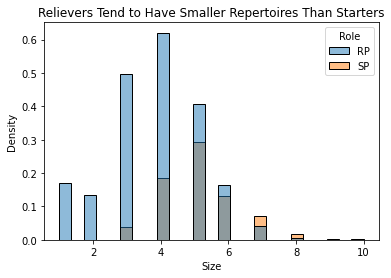

In [5]:
sns.histplot(data = MLB.groupby('player_name').apply(repertoire),
             x = 'Size',
             hue = 'Role',
            stat = 'density')
plt.title('Relievers Tend to Have Smaller Repertoires Than Starters')

In [6]:
MLB[['role_key', 'pitch_type','at_bat_number']].pivot_table(columns = 'pitch_type',
               index = 'role_key',
               aggfunc = 'count')

at_bat_number                                                       \
pitch_type            CH   CS      CU    EP     FC      FF   FO     FS     KC   
role_key                                                                        
RP                 84003  153   53381  1163  61869  304726  114  15332  13002   
SP                154070  150  107300     2  94951  412617  664  22764  29929   

                                                  
pitch_type   KN  SC      SI      SL     ST    SV  
role_key                                          
RP          134  74  149092  186032  35148   286  
SP          144   1  180077  191411  26239  7136

In [7]:
FG.groupby('Role')['Outs'].max()

Role
RP    253.0
SP    686.0
Name: Outs, dtype: float64

In [8]:
relieverLimits = range(254)
starterLimits = range(687)
FGRP = FG[FG['Role'] == 'RP']
FGSP = FG[FG['Role'] == 'SP']

# X = % of pitchers removed
# Y = % of outs still here
relieverX = [1 - (len(FGRP[FGRP['Outs'] >= x])/len(FGRP)) for x in relieverLimits]
relieverY = [FGRP[FGRP['Outs'] >= x]['Outs'].sum() / FGRP['Outs'].sum() for x in relieverLimits]

starterX = [1 - (len(FGSP[FGSP['Outs'] >= x])/len(FGSP)) for x in starterLimits]
starterY = [FGSP[FGSP['Outs'] >= x]['Outs'].sum() / FGSP['Outs'].sum() for x in starterLimits]

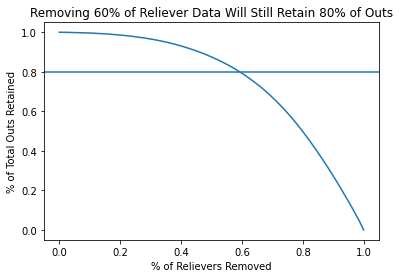

In [9]:
plt.plot(relieverX, relieverY)
plt.xlabel('% of Relievers Removed')
plt.ylabel('% of Total Outs Retained')
plt.title('Removing 60% of Reliever Data Will Still Retain 80% of Outs')
plt.axhline(.8)

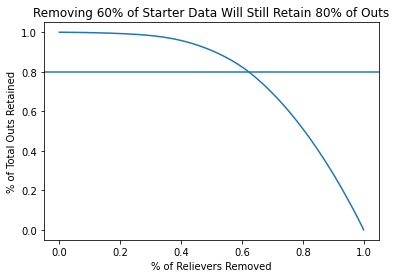

In [10]:
plt.plot(starterX, starterY)
plt.xlabel('% of Relievers Removed')
plt.ylabel('% of Total Outs Retained')
plt.title('Removing 60% of Starter Data Will Still Retain 80% of Outs')
plt.axhline(.8)

In [11]:
absDiff = float('inf')
for players,outs, limit in zip(relieverX,relieverY, relieverLimits):
    if abs(.9-outs) > absDiff:
        break
    absDiff = abs(.9-outs)

In [12]:
f'Filtering Relievers with less than {limit} outs will retain {round(outs,3)} of total outs while dropping {round(players,3)} of relievers'

'Filtering Relievers with less than 44 outs will retain 0.895 of total outs while dropping 0.469 of relievers'

In [13]:
absDiff = 1000000
for players,outs, limit in zip(starterX,starterY, starterLimits):
    if abs(.9-outs) > absDiff:
        break
    absDiff = abs(.9-outs)

In [14]:
f'Filtering Starters with less than {limit} outs will retain {round(outs,3)} of total outs while dropping {round(players,3)} of starters'

'Filtering Starters with less than 136 outs will retain 0.899 of total outs while dropping 0.514 of starters'

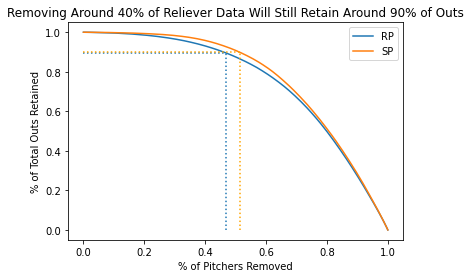

In [15]:
plt.plot(relieverX, relieverY, label = 'RP')
plt.plot(starterX, starterY, label = 'SP')
plt.xlabel('% of Pitchers Removed')
plt.ylabel('% of Total Outs Retained')
plt.title('Removing Around 40% of Reliever Data Will Still Retain Around 90% of Outs')
plt.legend()
plt.hlines(.895,0,.469,linestyle="dotted")
plt.vlines(.469,0,.895,linestyle="dotted")
plt.hlines(.899,0,.514,linestyle="dotted", color = 'orange')
plt.vlines(.514,0,.899,linestyle="dotted", color = 'orange')

In [16]:
qualified = FG[((FG['Outs'] >= 44) & (['Role'] == 'RP')) | (FG['Outs'] >= 136)]

In [17]:
def bootstrapTest(x, y, n = 10000):
    diff = []
    df = qualified.copy()[['Role'] + [x, y]]
    RP = df[df['Role'] == 'RP']
    RP_model = LinearRegression()
    RP_model.fit(X = RP[[x]],y = RP[y])
    SP = df[df['Role'] == 'SP']
    SP_model = LinearRegression()
    SP_model.fit(X = SP[[x]],y = SP[y])
    trueDiff = RP_model.coef_[0] - SP_model.coef_[0]
    negative = trueDiff < 0
    more_extreme = 0
    for i in range(n):
        df['Role'] = list(df['Role'].sample(frac = 1, random_state = i))
        RP = df[df['Role'] == 'RP']
        RP_model = LinearRegression()
        RP_model.fit(X = RP[[x]],y = RP[y])
        SP = df[df['Role'] == 'SP']
        SP_model = LinearRegression()
        SP_model.fit(X = SP[[x]],y = SP[y])
        sampleDiff = RP_model.coef_[0] - SP_model.coef_[0]
        diff += [sampleDiff]
        if negative:
            if sampleDiff <= trueDiff:
                more_extreme += 1
        else:
            if sampleDiff >= trueDiff:
                more_extreme += 1
    return (more_extreme/n, trueDiff, diff)

In [18]:
cols = qualified.columns.values
cols = [col for col in cols if col[-4:] == '_pct']
cols = [col for col in cols if sum(qualified[col].isna())==0]

In [19]:
experiments = [bootstrapTest(col, 'ERA') for col in cols]
p_vals = [i[0] for i in experiments]

In [20]:
sorted_p = sorted(p_vals)
alpha = .05
k, n = len(p_vals), len(p_vals)
for p in sorted_p[::-1]:
    if p <= (k*alpha/n):
        alpha = p
        break
    k -= 1

In [21]:
accepted_hypotheses = {col:exp[1] for col,exp in zip(cols,experiments) if exp[0] <= alpha}

In [22]:
k

18

Text(0.5, 1.0, 'Running Benjamini-Hochberg Analysis on our Tests')

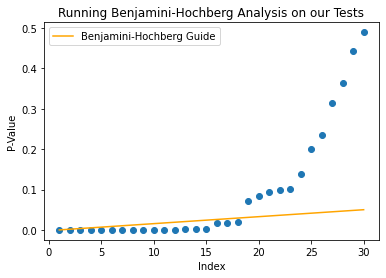

In [23]:
plt.scatter(range(1,n+1),sorted_p)
plt.plot([1,n],[0,.05], color = 'orange', label = 'Benjamini-Hochberg Guide')
plt.legend()
plt.xlabel('Index'),
plt.ylabel('P-Value')
plt.title('Running Benjamini-Hochberg Analysis on our Tests')

In [24]:
accepted_hypotheses

{'K_pct': 6.106304068421985,
 'BB_pct': -7.751014664096898,
 'K_minus_BB_pct': 4.528196776774752,
 'LOB_pct': 4.140379954987431,
 'GB_pct': 1.9152967913905756,
 'OSwing_pct': 8.25180189288153,
 'ZSwing_pct': -3.8727961199291427,
 'OContact_pct': -3.630607555823618,
 'ZContact_pct': -7.544558208744846,
 'Contact_pct': -7.533640339407392,
 'SwStr_pct': 12.605520515953122,
 'CSW_pct': 12.558781419107117,
 'Soft_pct': 6.69542300496678,
 'Med_pct': 4.1671345860195,
 'Hard_pct': -5.6648229687344545,
 'TTO_pct': 4.197006251178079,
 'Barrel_pct': -14.709756046219498,
 'HardHit_pct': -4.653131900498458}

In [25]:
def compare(x):
    sns.lmplot(data = qualified,
            x = x,
            y = 'ERA',
          hue = 'Role')

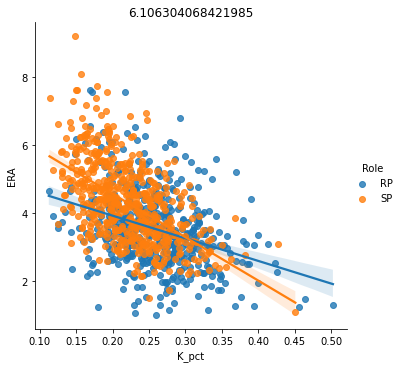

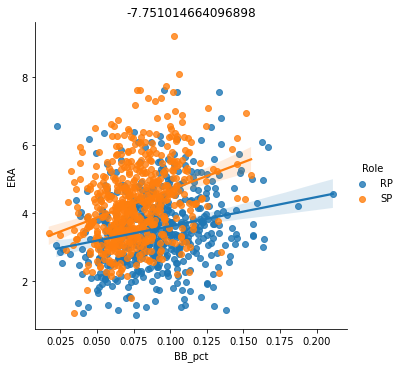

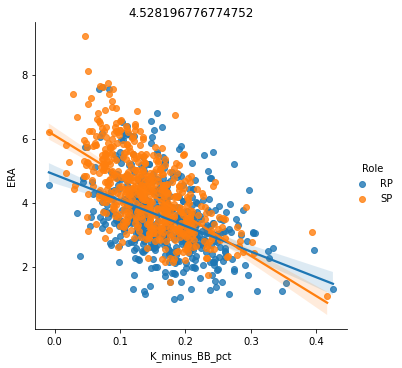

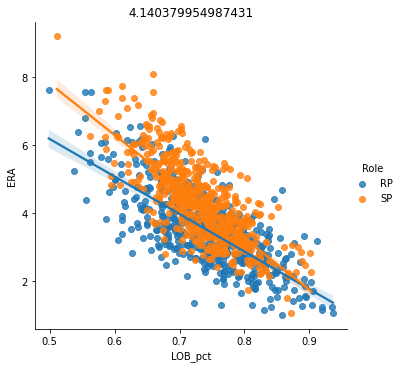

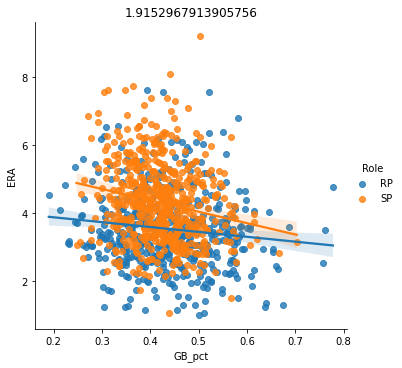

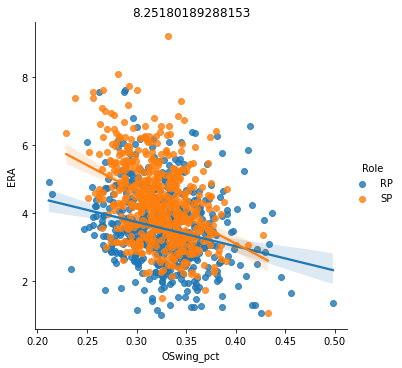

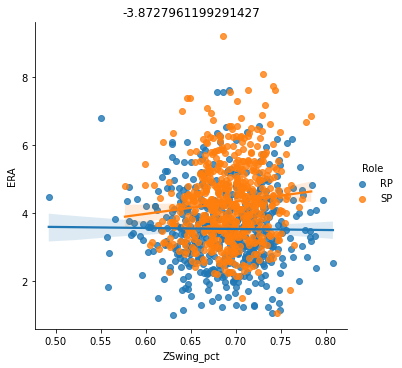

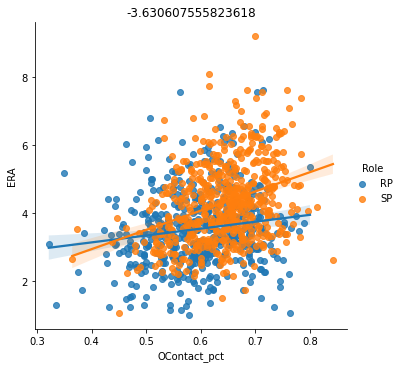

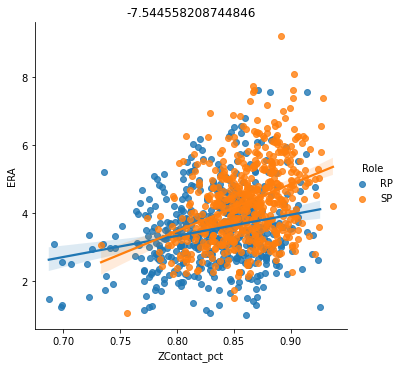

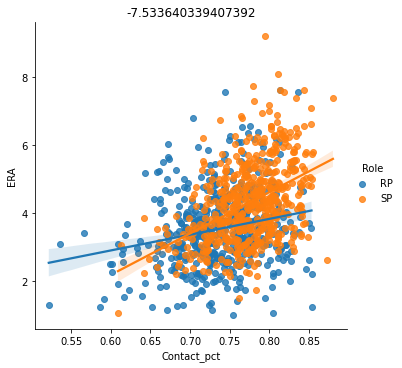

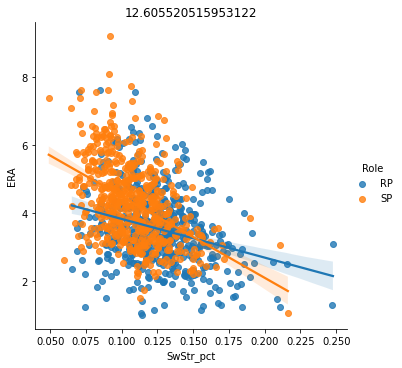

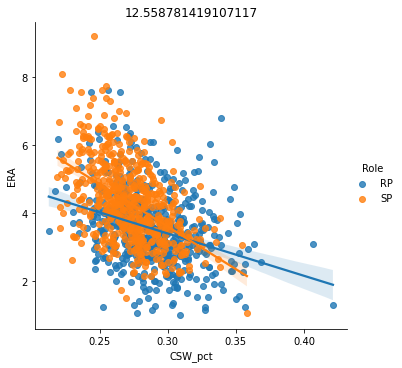

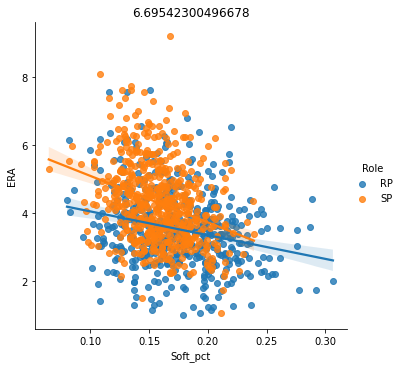

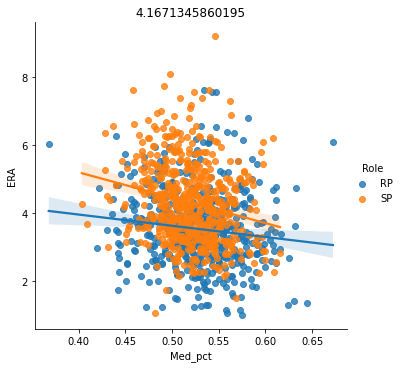

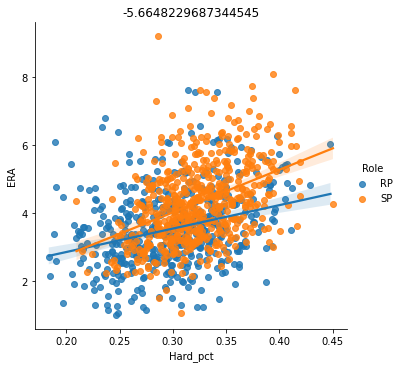

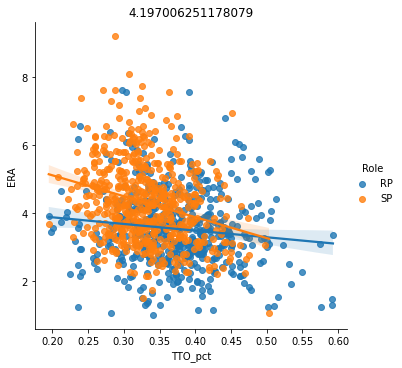

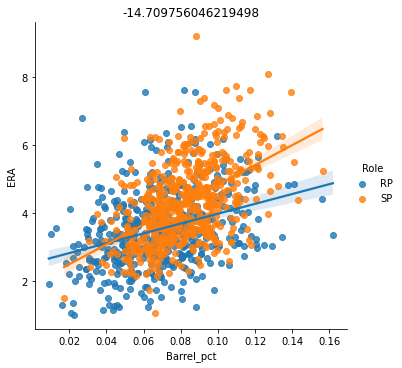

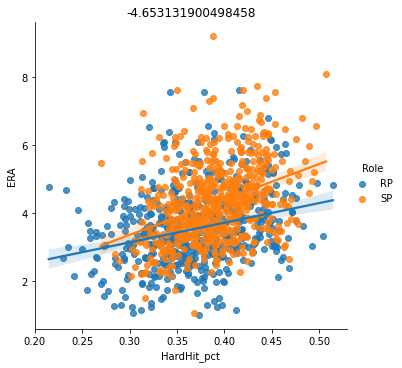

In [26]:
for col in accepted_hypotheses.keys():
    compare(col)
    plt.title(accepted_hypotheses[col])

In [27]:
def getFFdip(df):
    FF = df[df['pitch_type'] == 'FF']['release_speed']
    return pd.Series({'FF Velo Drop': FF.max() - FF.min(),
                     'Pitches Thrown': df['pitch_number_appearance'].max(),
                     'Role': df['role_key'].iloc[0]})

In [28]:
FF_velo_data = MLB.groupby(['game_pk','player_name']).apply(getFFdip).dropna(subset = ['FF Velo Drop'])
FF_velo_data['RP?'] = [1 if i == 'RP' else 0 for i in FF_velo_data['Role']]

(0.0, 10.0)

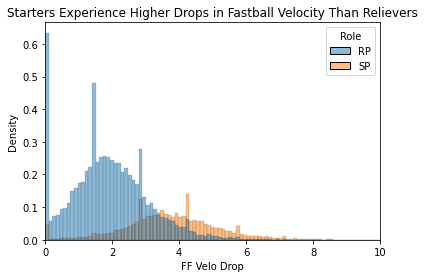

In [29]:
sns.histplot(data = FF_velo_data,
            x = 'FF Velo Drop',
            hue = 'Role',
            stat = 'density')
plt.title('Starters Experience Higher Drops in Fastball Velocity Than Relievers')
plt.xlim(0,10)

<Axes: xlabel='FF Velo Drop', ylabel='RP?'>

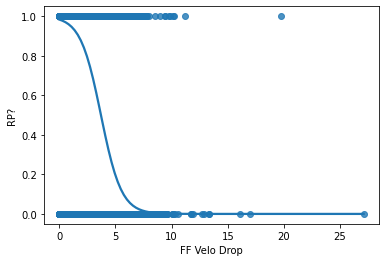

In [30]:
sns.regplot(data = FF_velo_data,
           x = 'FF Velo Drop',
           y = 'RP?',
           logistic = True)

In [31]:
FF_LR = LogisticRegression(fit_intercept = True)
FF_LR.fit(X = FF_velo_data[['FF Velo Drop']],
         y = FF_velo_data['RP?'])

LogisticRegression()

In [32]:
FF_velo_data['Role By Velo Drop'] = FF_LR.predict(FF_velo_data[['FF Velo Drop']])

In [33]:
FF_velo_data.reset_index().groupby('player_name')['Role By Velo Drop'].mean()['Corbin, Patrick']

0.6344086021505376

In [34]:
FF_velo_data[FF_velo_data['RP?'] != FF_velo_data['Role By Velo Drop']]

FF Velo Drop  Pitches Thrown Role  RP?  \
game_pk player_name                                                   
632169  Webb, Logan                   2.9              92   SP    0   
632188  DeSclafani, Anthony           2.9              94   SP    0   
632190  Alcala, Jorge                 4.5              15   RP    1   
        Happ, J.A.                    3.3              87   SP    0   
632191  Urías, Julio                  3.0              95   SP    0   
...                                   ...             ...  ...  ...   
718779  Ragans, Cole                  4.4               5   RP    1   
718780  Corbin, Patrick               2.7              85   SP    0   
718781  Webb, Logan                   0.3              92   SP    0   
718782  Bautista, Félix               4.4              25   RP    1   
        Brasier, Ryan                 3.8              35   RP    1   

                             Role By Velo Drop  
game_pk player_name                             
632169  Webb, Logan                          1  
632188  DeSclafani, Anthony                  1  
632190  Alcala, Jorge                        0  
        Happ, J.A.                           1  
632191  Urías, Julio                         1  
...                                        ...  
718779  Ragans, Cole                         0  
718780  Corbin, Patrick                      1  
718781  Webb, Logan                          1  
718782  Bautista, Félix                      0  
        Brasier, Ryan                        0  

[9226 rows x 5 columns]

In [35]:
SP_FF_dip = FF_velo_data[FF_velo_data['Role'] == 'SP'].reset_index().groupby('player_name')[['FF Velo Drop']].mean()

In [36]:
SP_FF_dip.sort_values('FF Velo Drop', ascending = False).head(30)

,FF Velo Drop
player_name,
"Santiago, Héctor",6.700000
"Ohtani, Shohei",6.455405
"Waldron, Matt",6.366667
"Rodón, Carlos",6.320290
"Smith-Shawver, AJ",6.280000
"Oviedo, Luis",6.200000
"Baz, Shane",6.133333
"Fried, Max",6.127778
"Flaherty, Jack",6.094000


In [37]:
RP_pitches = MLB[MLB['role_key'] == 'RP'].groupby('player_name').apply(lambda x: pd.Series({'Average Pitches/Game':x.groupby('game_pk')['pitch_number_appearance'].max().mean(),
                                                                                            'Games': len(x['game_pk'].unique())}))

In [38]:
RP_pitches[RP_pitches['Games'] > 20].sort_values('Average Pitches/Game').tail(20)

,Average Pitches/Game,Games
player_name,,
"Soriano, George",32.960000,25.0
"Wesneski, Hayden",33.040000,25.0
"Velasquez, Vince",33.181818,22.0
"Winder, Josh",34.434783,23.0
"Bielak, Brandon",34.515152,33.0
"Junis, Jakob",34.750000,52.0
"Nogosek, Stephen",35.153846,26.0
"Lawrence, Casey",35.428571,21.0
"Allard, Kolby",35.692308,26.0


In [39]:
def slideIn(player, x):
    df = qualified.copy()
    sns.lmplot(data = df,
              x = x,
              y = 'ERA',
              hue = 'Role')
    df = FG.copy()
    df[df['G'] >=5]
    playerDF = df[df['NameASCII'] == player]
    plt.scatter(x = playerDF[x], y = playerDF['ERA'], color = 'red', label = player)
    plt.legend()

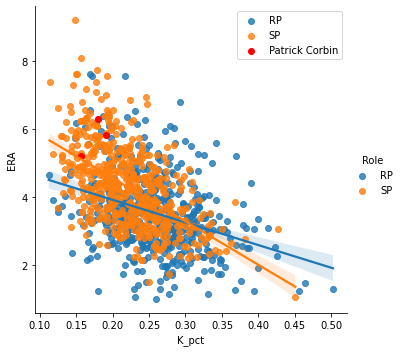

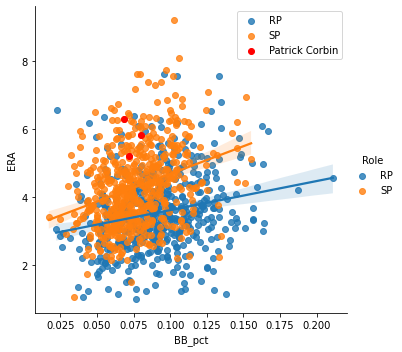

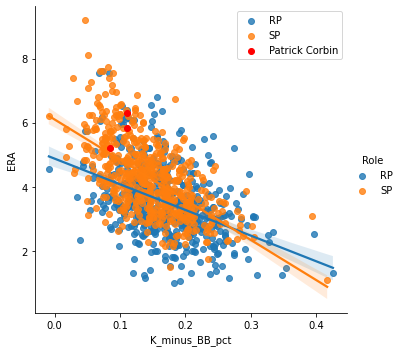

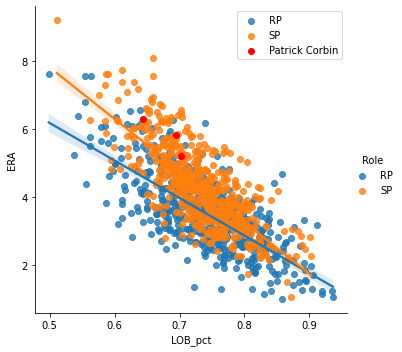

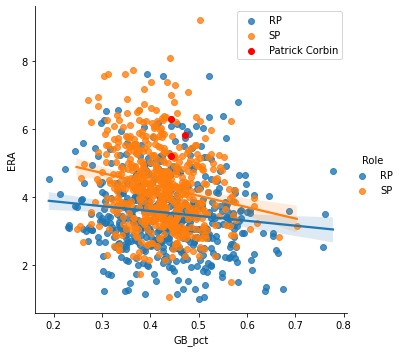

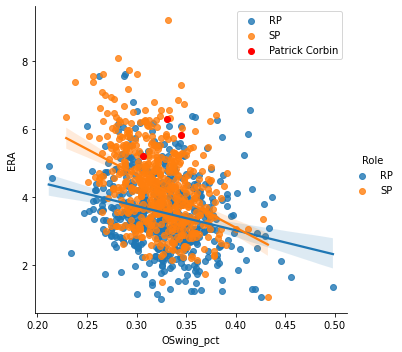

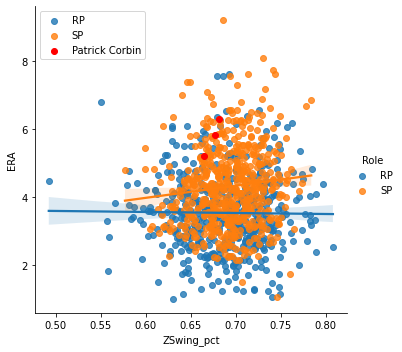

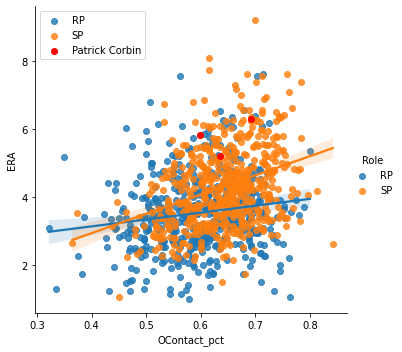

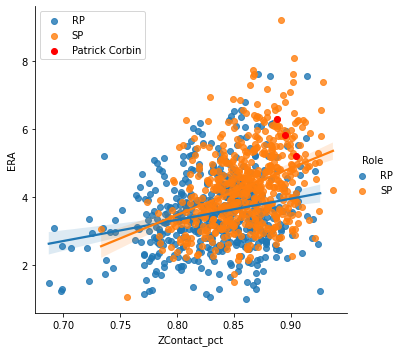

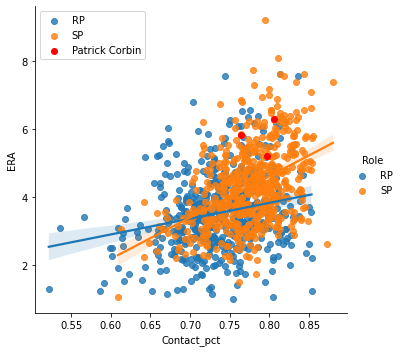

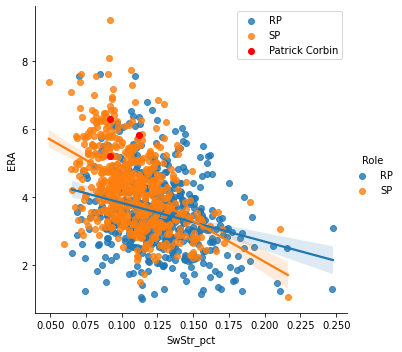

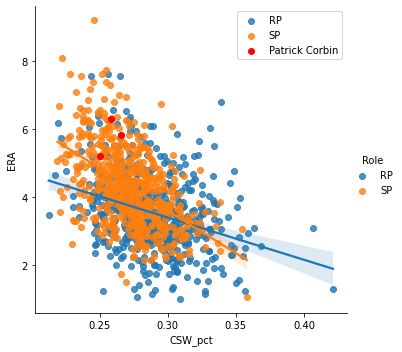

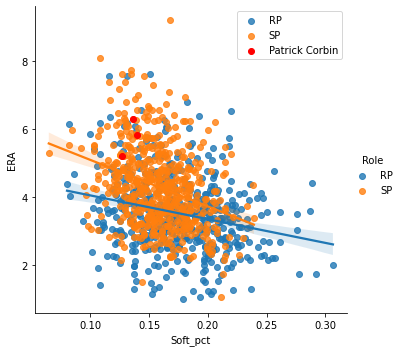

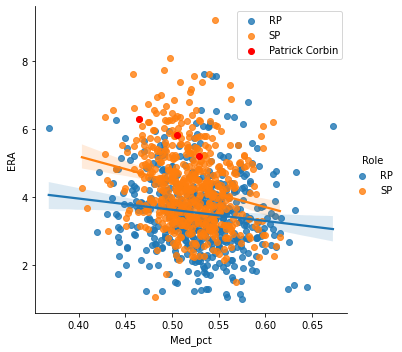

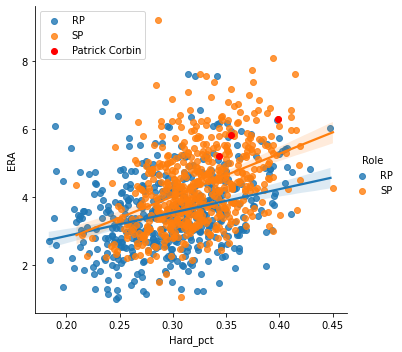

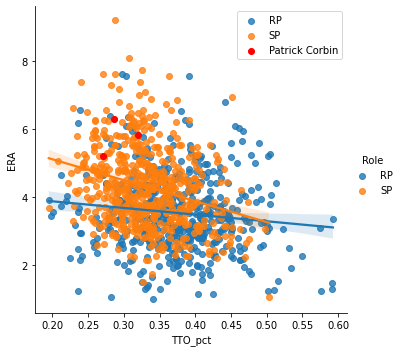

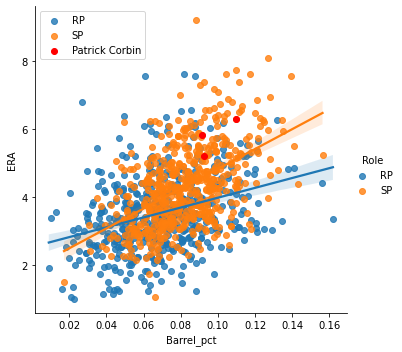

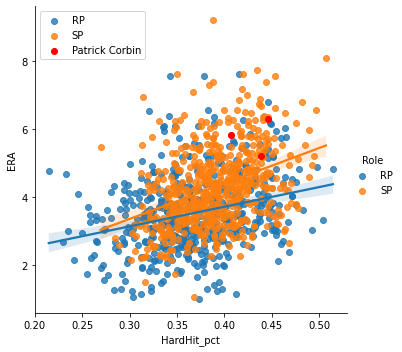

In [40]:
for col in accepted_hypotheses.keys():
    slideIn('Patrick Corbin', col)

Text(0.5, 1.0, "Patrick Corbin's Low Strikeout Rate Contributes to His Poor Performances as a Starter")

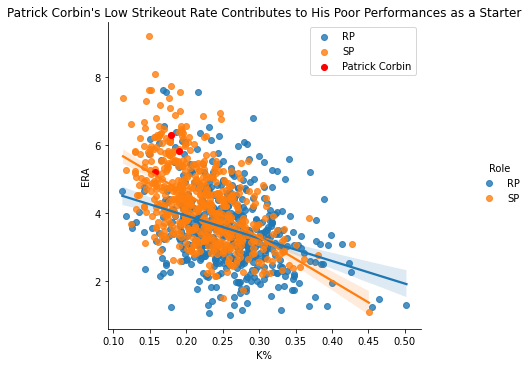

In [41]:
slideIn('Patrick Corbin', 'K_pct')
plt.xlabel('K%')
plt.title("Patrick Corbin's Low Strikeout Rate Contributes to His Poor Performances as a Starter")

Text(0.5, 1.0, "Patrick Corbin's High Contact Rate Contributes to His Poor Performances as a Starter")

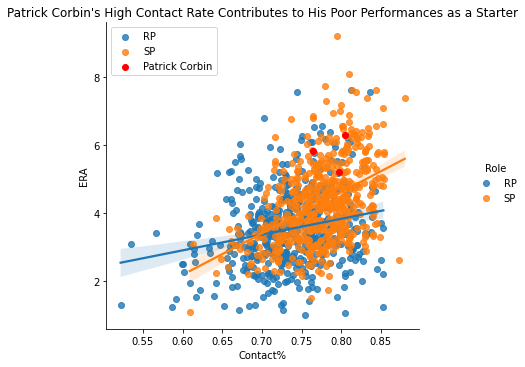

In [42]:
slideIn('Patrick Corbin', 'Contact_pct')
plt.xlabel('Contact%')
plt.title("Patrick Corbin's High Contact Rate Contributes to His Poor Performances as a Starter")

In [43]:
def pitchDistribution(player):
    return MLB[MLB['player_name'] == player]['pitch_type'].value_counts()/len(MLB[MLB['player_name'] == player])

In [44]:
pitchDistribution('Corbin, Patrick')

SI    0.382761
SL    0.342978
FF    0.207354
CH    0.062688
CU    0.003255
FC    0.000964
Name: pitch_type, dtype: float64

In [45]:
pitchDistribution('Urquidy, José')

FF    0.504751
CH    0.172536
ST    0.164151
CU    0.114962
FC    0.023849
SI    0.019750
Name: pitch_type, dtype: float64

In [46]:
FG_look = lambda x: FG[FG['NameASCII'] == x]

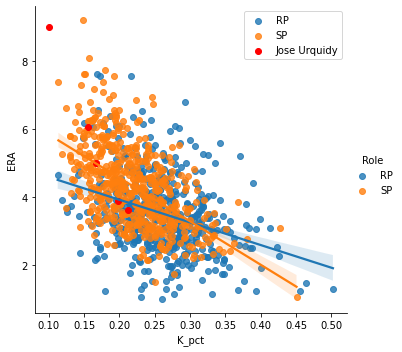

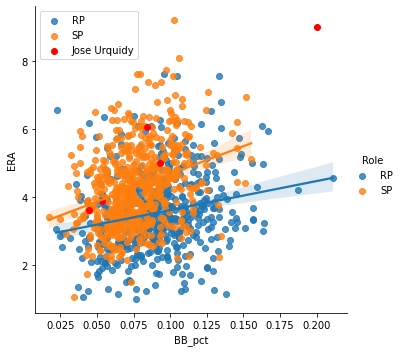

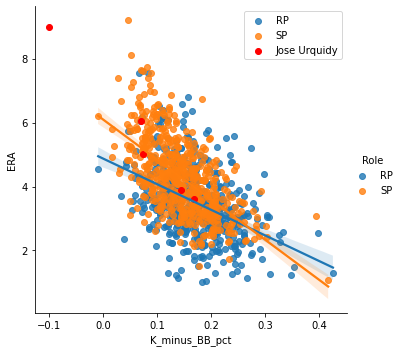

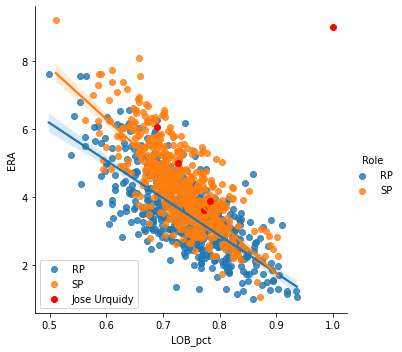

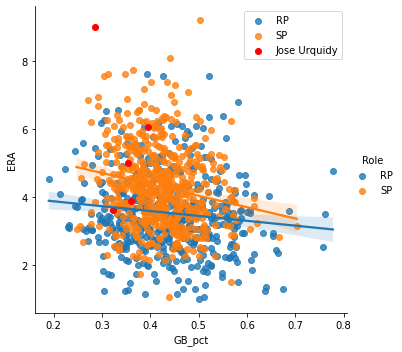

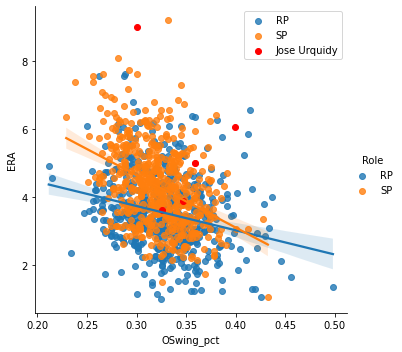

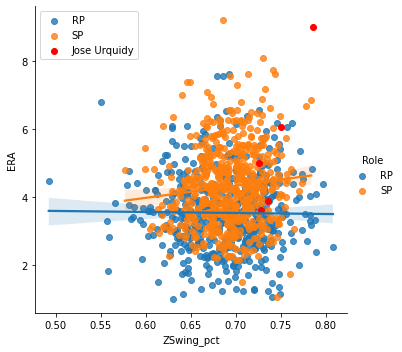

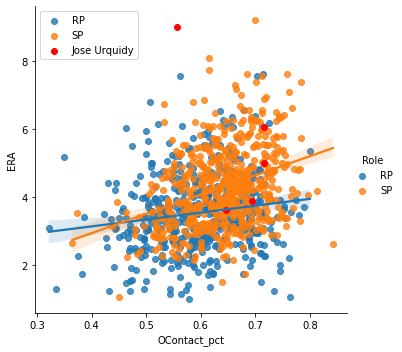

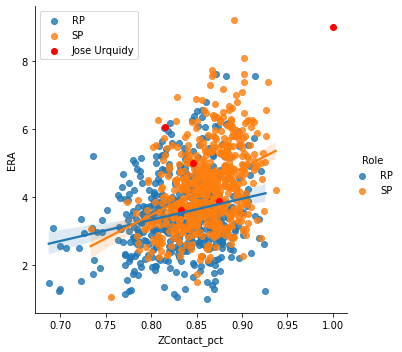

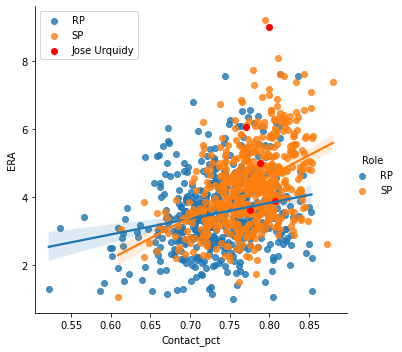

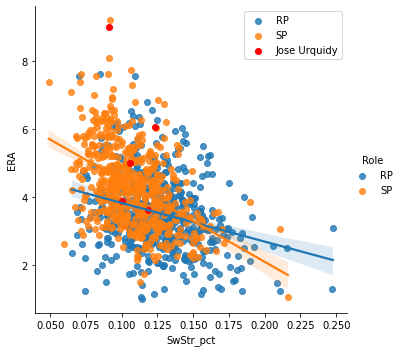

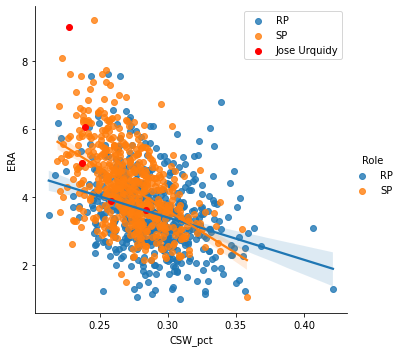

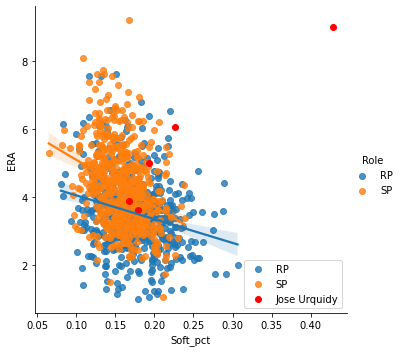

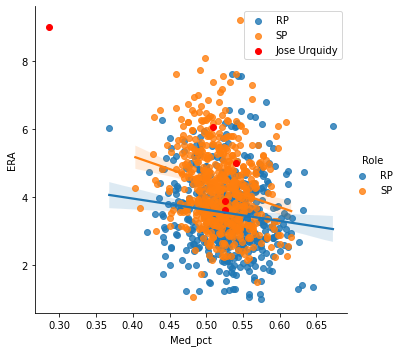

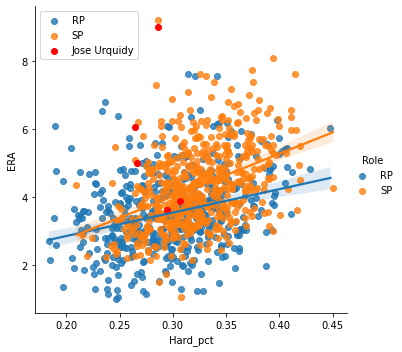

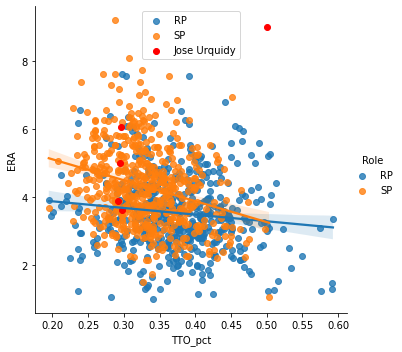

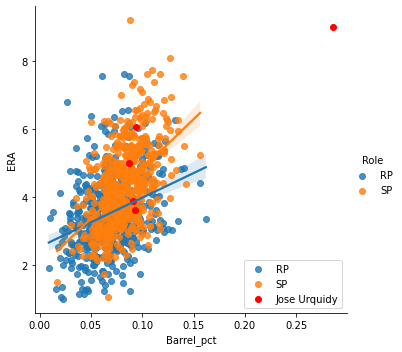

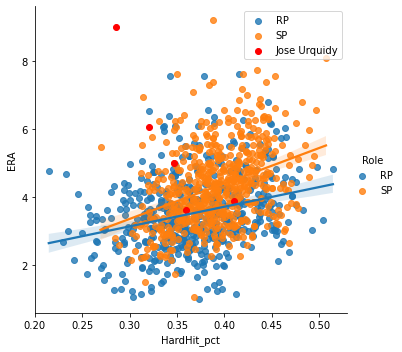

In [47]:
for col in accepted_hypotheses.keys():
    slideIn('Jose Urquidy', col)

In [48]:
SP_FF_dip['Urquidy, Jose':]

,FF Velo Drop
player_name,
"Urquidy, José",4.224138
"Urías, Julio",4.095238
"Valdez, Framber",2.360000
"Varland, Louie",3.760000
"Velasquez, Vince",3.955263
...,...
"Zerpa, Angel",3.083333
"Zeuch, T.J.",0.800000
"Zimmer, Kyle",3.150000


Text(0.5, 1.0, 'Jose Urquidy Exhibits a High Contact Rate')

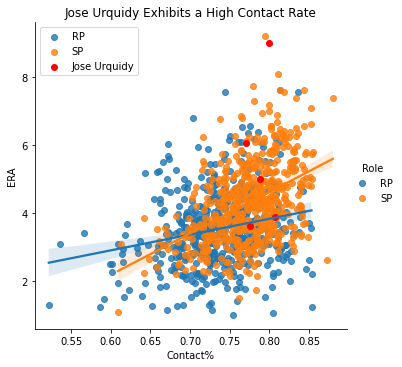

In [49]:
slideIn('Jose Urquidy', 'Contact_pct')
plt.xlabel('Contact%')
plt.title("Jose Urquidy Exhibits a High Contact Rate")